# <center>**Facial Expression Recognition**</center>



# Context of the Project:
The [**RAF-DB (Real-World Affective Face Database)**](http://https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset) is a dataset that contains images of human faces labeled with seven emotional expressions: **happy** (bonheur), **angry** (colère), **sad** (tristesse), **fear** (peur), **disgust** (dégoût), **surprise** (surprise) and neutral (neutre). These emotions are critical for various applications in human-computer interaction, psychology, and affective computing.

Facial emotion recognition (FER) is a subfield of computer vision that focuses on identifying human emotions from facial expressions. Recognizing emotions from faces has practical applications in fields such as:

* **Customer service:** Analyzing customer satisfaction in real-time.
* **Security:** Identifying suspicious or threatening individuals.
* **Healthcare:** Monitoring emotional states in patients, especially those with mental health conditions.
* **Human-robot interaction:** Improving communication between humans and robots.

The challenge in this project is the imbalance in the classes, as some emotions are more prevalent than others, which can affect the performance of models trained on such data.

# Objective of the Project:

The main objective of this notebook is to classify the facial expressions from the RAF-DB dataset into seven categories based on the emotions they represent. Specifically, the objectives include:

1.  **Preprocess the data:** This involves loading, resizing, and normalizing images while addressing class imbalance (e.g., some emotions may be underrepresented in the dataset).

2. **Build and compare models:** The project will involve training three different types of models and comparing their performance:
    * **Machine Learning Model (SVM - Support Vector Machine) :** This traditional machine learning model will be used as a baseline for classification.
    * **CNN (Convolutional Neural Network) :** A deep learning model that can automatically learn features from images and will be evaluated for its ability to classify emotions.
    * **Transfer Learning (DenseNet) :** Pre-trained models like DenseNet, which have already learned useful features from large datasets like ImageNet, will be fine-tuned for the task of emotion recognition.

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">data understanding</p>

In [1]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session
import gc


In [2]:
# Load the labels CSV files
train_labels = pd.read_csv('/kaggle/input/raf-db-dataset/train_labels.csv')
test_labels = pd.read_csv('/kaggle/input/raf-db-dataset/test_labels.csv')

# Display the first few rows of the train labels to check the structure
print(train_labels.head())

classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']


label_map = {label: (idx+1) for idx, label in enumerate(classes)}

print(label_map)

                     image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5
{'surprise': 1, 'fear': 2, 'disgust': 3, 'happy': 4, 'sad': 5, 'angry': 6, 'neutral': 7}


In [3]:
# Function to load images and labels from the directory
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    
    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))  # +1 because folder names start from '1'
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)
    
    return np.array(images), np.array(labels)

# Load train and test datasets
train_images, train_labels = load_data('/kaggle/input/raf-db-dataset/DATASET/train', label_map)
test_images, test_labels = load_data('/kaggle/input/raf-db-dataset/DATASET/test', label_map)
print(train_images.shape)
print(test_images.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

(12271, 100, 100, 3)
(3068, 100, 100, 3)


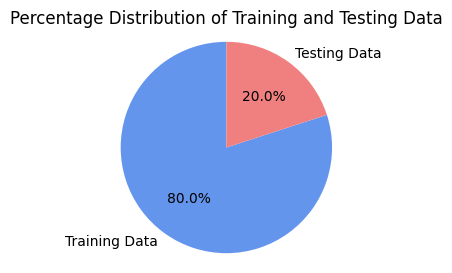

In [4]:
# Calculate the total number of images
total_images = len(train_images) + len(test_images)

# Calculate percentages
train_percentage = (len(train_images) / total_images) * 100
test_percentage = (len(test_images) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


train_label_counts  Counter({4: 4772, 7: 2524, 5: 1982, 1: 1290, 3: 717, 6: 705, 2: 281})
test_counts [329, 74, 160, 1185, 478, 162, 680]


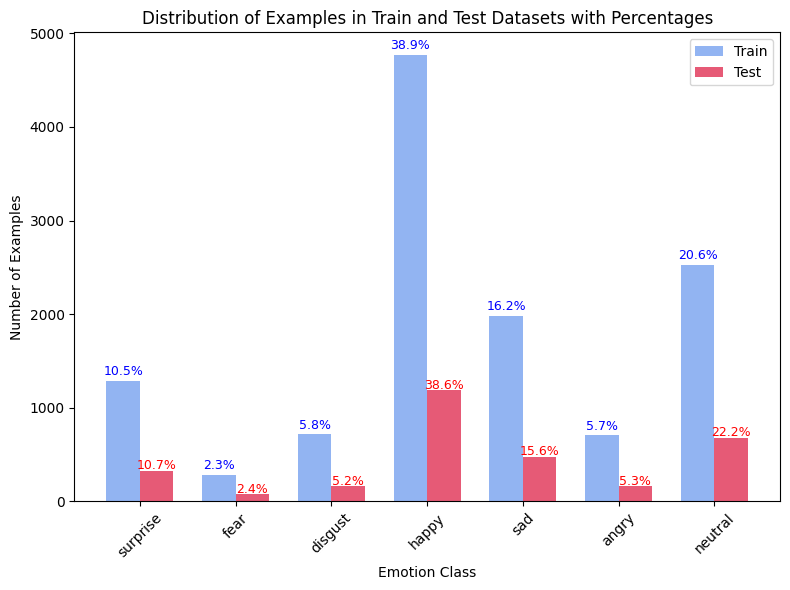

In [5]:
# Count the distribution of classes in train and test datasets
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
print('train_label_counts ',train_label_counts)
# Convert to sorted lists for plotting
train_classes = sorted(train_label_counts.keys())
train_counts = [train_label_counts[cls] for cls in train_classes]

test_classes = sorted(test_label_counts.keys())
test_counts = [test_label_counts[cls] for cls in test_classes]
print('test_counts',test_counts)
# Calculate the total number of examples in train and test datasets
total_train = sum(train_counts)
total_test = sum(test_counts)

# Calculate percentages for train and test datasets
train_percentages = [(count / total_train) * 100 for count in train_counts]
test_percentages = [(count / total_test) * 100 for count in test_counts]

# Plot the distribution with percentages
plt.figure(figsize=(8, 6))
x = range(len(classes))
bar_width = 0.35

plt.bar(x, train_counts, width=bar_width, label="Train", alpha=0.7, color="cornflowerblue")
plt.bar([p + bar_width for p in x], test_counts, width=bar_width, label="Test", alpha=0.7, color="crimson")

# Annotate percentages on bars
for i, (train_count, test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(i, train_count + 0.005 * total_train, f"{train_percentages[i]:.1f}%", ha='center', color="blue", fontsize=9)
    plt.text(i + bar_width, test_count + 0.005 * total_test, f"{test_percentages[i]:.1f}%", ha='center', color="red", fontsize=9)

# Add labels and title
plt.xticks([p + bar_width / 2 for p in x], classes, rotation=45)
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title("Distribution of Examples in Train and Test Datasets with Percentages")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

> The dataset shows a clear class imbalance, with **Happy** being the dominant class (39,9%) and **Fear** and **Angry** being underrepresented (2,3% and 5,7%). This imbalance may lead the model to favor the majority class, causing poor performance for minority classes. The distribution is consistent across train and test sets, but techniques like class weighting, oversampling, or data augmentation are needed to address this imbalance and improve model performance.

In [6]:
# Combine the train and test datasets into the same variables
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)

# Display the shapes to confirm
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)



> To simplify the preprocessing steps, the training and testing datasets are merged into a single dataset.
> This is achieved by **concatenating** the images (train_images and test_images) and their corresponding labels (train_labels and test_labels) along the first axis, creating unified variables for further processing.
> 
> This combined dataset will allow for unified data augmentation and preprocessing steps before splitting it again for model training and evaluation. The shapes of the resulting arrays are displayed to verify the merge."


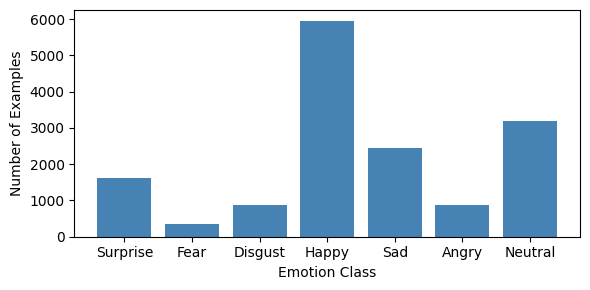

In [7]:
# Count the distribution of classes in the resampled train dataset
train_label_counts_resampled = Counter(Y_train)
    
# Convert to sorted lists for plotting
train_classes_resampled = sorted(train_label_counts_resampled.keys())
train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
# Plot the distribution
plt.figure(figsize=(6, 3))
x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
    
# Bar plot for the resampled distribution
plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
# Add labels and title
plt.xlabel("Emotion Class")
plt.ylabel("Number of Examples")
plt.title('')
plt.tight_layout()
    
# Show the plot
plt.show()

In [8]:
# Shuffle X_train and Y_train
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

# Display the shapes to confirm the data is shuffled
print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


> To ensure the training data is presented to the model in a random order, we shuffle the **X_train** and **Y_train** datasets using a fixed random state for reproducibility. This step helps prevent the model from learning any unintended patterns from the data ordering, improving the overall training process. 

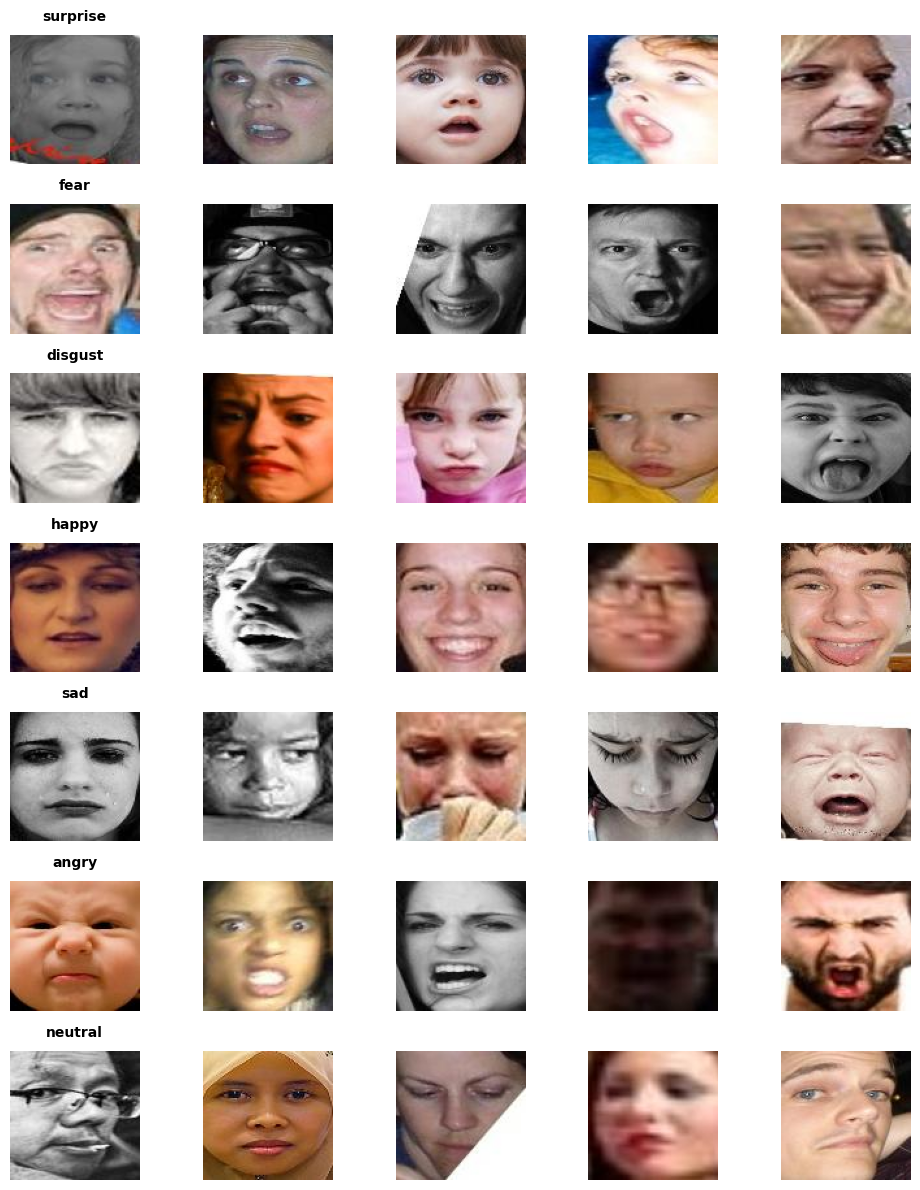

In [9]:
def show_examples(train_images, train_labels, labels, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 12))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(train_labels) if label == i+1]
        selected_indices = np.random.choice(class_indices, num_examples, replace=False)
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        # Display the random images for the current class
        for j, idx in enumerate(selected_indices):
            img = train_images[idx]
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images for each class
show_examples(X_train, Y_train, classes)

In [10]:
# most frequent image sizes :
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# show most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (100, 100, 3): 15339


> The most frequent image shape in the training dataset is **(100, 100, 3)**, with **12,271** images in this resolution. Since the majority of the dataset already has a consistent size of **100x100 pixels** with three color channels (RGB), there is no need to resize the images. Maintaining their original dimensions avoids unnecessary computational overhead and preserves the quality and features of the data. This consistency simplifies preprocessing and ensures the model receives inputs in their native resolution, which can lead to better feature extraction and improved model performance.

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">data preparation</p>



**1. Oversampling**

> In this notebook, we address class **imbalance** by applying oversampling techniques. First, we **reduce** the size of the **'happy'** class to a target count using random sampling. Then, we **augment** the classes with fewer samples by generating additional images through data augmentation techniques such as rotation, translation, zooming, and horizontal flipping. This ensures a balanced distribution of classes, making the model training more robust and improving its performance on underrepresented classes. The final dataset distribution is visualized after both the reduction and augmentation processes to confirm the effectiveness of these techniques.

In [11]:
# Function to plot the class distribution
def plot_class_distribution(y, title):
    # Count the distribution of classes in the resampled train dataset
    train_label_counts_resampled = Counter(y)
    
    # Convert to sorted lists for plotting
    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_label_counts_resampled[cls] for cls in train_classes_resampled]
    
    # Plot the distribution
    plt.figure(figsize=(6, 3))
    x_labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']
    
    # Bar plot for the resampled distribution
    plt.bar(x_labels, train_counts_resampled, color="steelblue")
    
    # Add labels and title
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

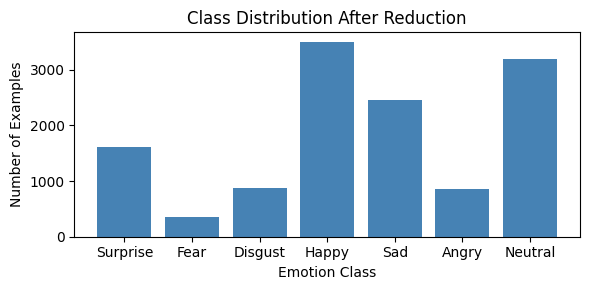

In [12]:
# Function to reduce the size of a specific class in the dataset
def reduce_class(X, y, target_class, target_size):
    # Separate the target class
    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    
    # Randomly sample the target class to the desired size
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    
    # Combine the reduced class with the other classes
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]
    
    return X_reduced, y_reduced

target_class = 4  # The 'happy' class
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
# Plot the new distribution after reduction
plot_class_distribution(y_train_reduced, "Class Distribution After Reduction")

Classe 1: 1619 échantillons augmentés avec 1881 échantillons.
Classe 2: 355 échantillons augmentés avec 3145 échantillons.
Classe 3: 877 échantillons augmentés avec 2623 échantillons.
Classe 5: 2460 échantillons augmentés avec 1040 échantillons.
Classe 6: 867 échantillons augmentés avec 2633 échantillons.
Classe 7: 3204 échantillons augmentés avec 296 échantillons.


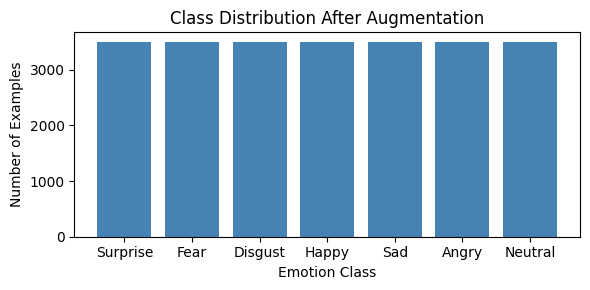

In [13]:
def augment_classes(images, labels, target_counts):
    # Initialisation de la génération d'images augmentées
    datagen = ImageDataGenerator(
        rotation_range=10,             
        width_shift_range=0.1,         
        height_shift_range=0.1,  
        zoom_range=0.1,
        vertical_flip=False,               
        horizontal_flip=True, 
        channel_shift_range=50.0,
        fill_mode='nearest'
    )

    augmented_images = images.copy()  # Nous copions les images pour conserver les originales
    augmented_labels = labels.copy()  # Idem pour les labels

    # Pour chaque classe, nous augmentons le nombre d'échantillons
    for target_class, target_count in target_counts.items():
        # Filtrage des images et labels pour la classe cible
        class_images = images[labels == target_class]
        class_labels = labels[labels == target_class]
        # Calcul du nombre d'échantillons à générer
        augment_count = target_count - len(class_images)

        if augment_count > 0:
            print(f'Classe {target_class}: {len(class_images)} échantillons augmentés avec {augment_count} échantillons.')

            # Création d'un itérateur pour la classe cible
            class_images_augmented = []
            class_labels_augmented = []

            # Appliquer l'augmentation de manière itérative
            for batch in datagen.flow(class_images, batch_size=1, seed=42):
                aug_image = batch[0].astype(np.uint8)
                class_images_augmented.append(aug_image)
                class_labels_augmented.append(target_class)
                
                # Arrêter quand le nombre souhaité d'images augmentées est atteint
                if len(class_images_augmented) >= augment_count:
                    break
            
            # Ajouter les images augmentées au jeu de données original
            augmented_images = np.vstack((augmented_images, np.array(class_images_augmented)))
            augmented_labels = np.hstack((augmented_labels, np.array(class_labels_augmented)))

    return augmented_images, augmented_labels

# Example usage
target_counts = {1: 3500, 2: 3500, 3: 3500, 5: 3500, 6: 3500, 7: 3500}  # Target counts for each class
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

# Visualize the class distribution after augmentation
plot_class_distribution(y_train_augmented, "Class Distribution After Augmentation")

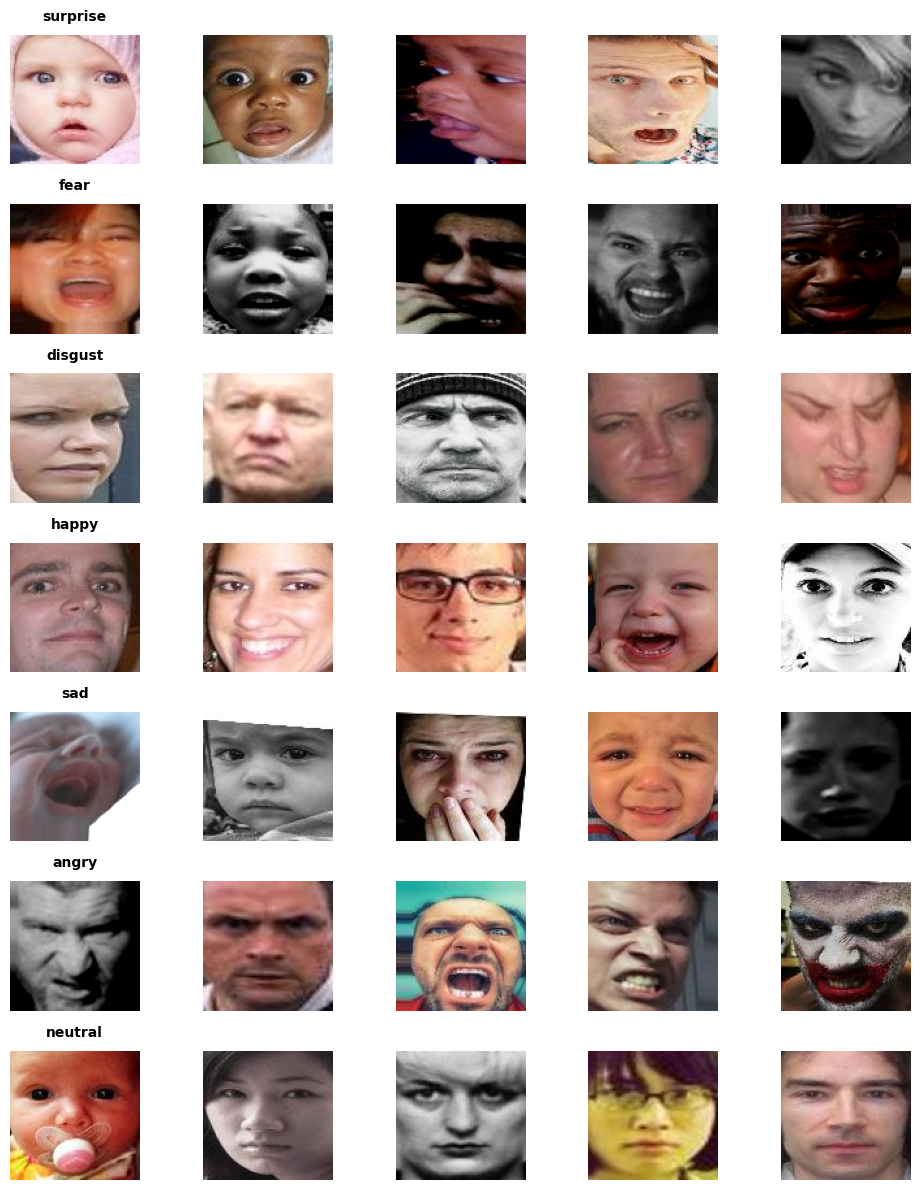

In [14]:
# Show sample images for each class
show_examples(X_train_augmented, y_train_augmented, classes)

**Split**



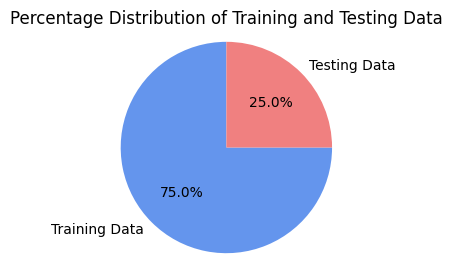

In [15]:
# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented, 
                                                    y_train_augmented, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    random_state=42)

# Calculate the total number of images
total_images = len(X_train) + len(X_test)

# Calculate percentages
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100

# Data for pie chart
labels = ['Training Data', 'Testing Data']
sizes = [train_percentage, test_percentage]
colors = ['cornflowerblue', 'lightcoral']

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')  
plt.show()


> The dataset is split into training and testing sets, with 80% allocated for training and 20% for testing, using the train_test_split function. TThis separation is crucial for evaluating the model's generalization ability on unseen data.

**2. Normalize the images**

In [16]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0

train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

> To standardize the pixel values and ensure consistent input for the model, the image data is normalized by scaling the pixel values to a **range of [0, 1]**. This is achieved by dividing the pixel values by 255, the maximum pixel value for an 8-bit image. Both the training and testing images are normalized using this approach to facilitate better model performance and faster convergence during training.

**3. Reshape the images**

In [17]:
def reshape_images(images, model_type='CNN'):
    if model_type == 'SVM':
        # SVM needs the images to be flattened (1D)
        return images.reshape((images.shape[0], -1))
    elif model_type in ['CNN']:
        # CNN and DenseNet require images to have shape (height, width, channels)
        return images.reshape((images.shape[0], 100, 100, 3))

train_images_SVMreshaped = reshape_images(train_images_normalized, model_type='SVM')
test_images_SVMreshaped = reshape_images(test_images_normalized, model_type='SVM')

train_images_CNNreshaped = reshape_images(train_images_normalized, model_type='CNN')
test_images_CNNreshaped = reshape_images(test_images_normalized, model_type='CNN')

> In this step, the images are reshaped to fit the requirements of different models.
> * For the Support Vector Machine (SVM), the images are flattened into one-dimensional arrays, as SVM models expect feature vectors as input.
> * On the other hand, for Convolutional Neural Networks (CNN) and models like DenseNet, the images are reshaped to maintain their spatial structure, with dimensions corresponding to height, width, and color channels.
>   
> This reshaping ensures that the images are in the correct format for each model type and can be effectively processed during training and testing.


**6. Convert labels to categorical**

In [18]:
# Convert labels to categorical for CNN
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes))

> The labels are converted to one-hot encoded format, adjusting them by subtracting 1 to match the index range. This conversion is crucial for models like CNN, which require the target labels to be in a categorical format (as vectors) to compute the loss function during training and evaluation. The number of categories is defined by the total number of classes in the dataset."

**4. Data Augmentation for CNN and DenseNet**

In [19]:
datagen = ImageDataGenerator(
    rotation_range=20,             
    width_shift_range=0.1,         
    height_shift_range=0.1,  
    vertical_flip=False,               
    horizontal_flip=True, 
    fill_mode='nearest'
)

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

> To enhance the model's ability to generalize, data augmentation is applied using **ImageDataGenerator**. This involves applying random transformations, which helps the model become more robust to variations in the input images. 

**5. Standardization for SVM model**

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_images_SVMreshaped = scaler.fit_transform(train_images_SVMreshaped)
test_images_SVMreshaped = scaler.transform(test_images_SVMreshaped)

> The **StandardScaler** is applied to the reshaped images for the SVM model, ensuring that each feature has a mean of 0 and a standard deviation of 1. This step helps improve the performance of the SVM by making the features comparable and more suitable for the algorithm.

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">SVM Model</p>

**SVM model**

In [21]:
# Set up the SVM model
svm_model = LinearSVC(C=1, class_weight='balanced')

# Train the SVM model
print('training in progress...')
svm_model.fit(train_images_SVMreshaped, Y_train)
print('training finished !') 

training in progress...
training finished !


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
# Predict on the test set
y_SVMpred = svm_model.predict(test_images_SVMreshaped)

# Evaluate the model
print(f"Accuracy on Test Set: {accuracy_score(Y_test, y_SVMpred):.4f}")
print(f"Classification Report:\n{classification_report(Y_test, y_SVMpred)}")

Accuracy on Test Set: 0.3682
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.35      0.34       870
           2       0.32      0.28      0.29       840
           3       0.27      0.28      0.28       910
           4       0.57      0.65      0.61       887
           5       0.29      0.26      0.28       865
           6       0.30      0.27      0.28       859
           7       0.43      0.48      0.46       894

    accuracy                           0.37      6125
   macro avg       0.36      0.37      0.36      6125
weighted avg       0.36      0.37      0.36      6125



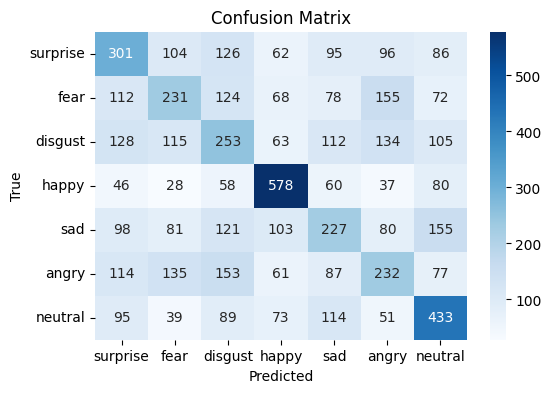

In [23]:
conf_matrix = confusion_matrix(Y_test, y_SVMpred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(Y_test)
y_pred_prob = svm_model.decision_function(test_images_SVMreshaped)

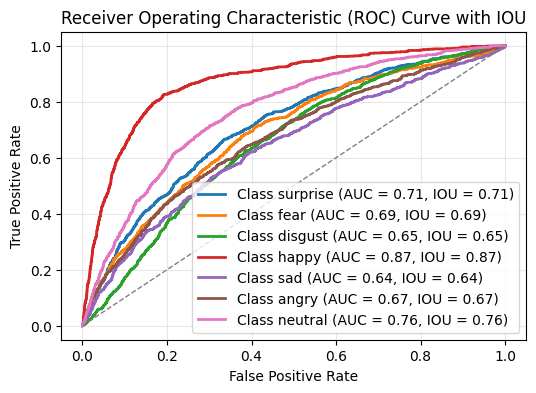

In [25]:
# Initialize dictionaries for FPR, TPR, and IOU
fpr = {}
tpr = {}
roc_auc = {}
iou_scores = {}

# Compute ROC curve, AUC, and IOU for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Calculate IOU as the area under the TPR curve minus FPR area
    iou_scores[i] = np.trapz(tpr[i], fpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(6, 4))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f}, IOU = {iou_scores[i]:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with IOU')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

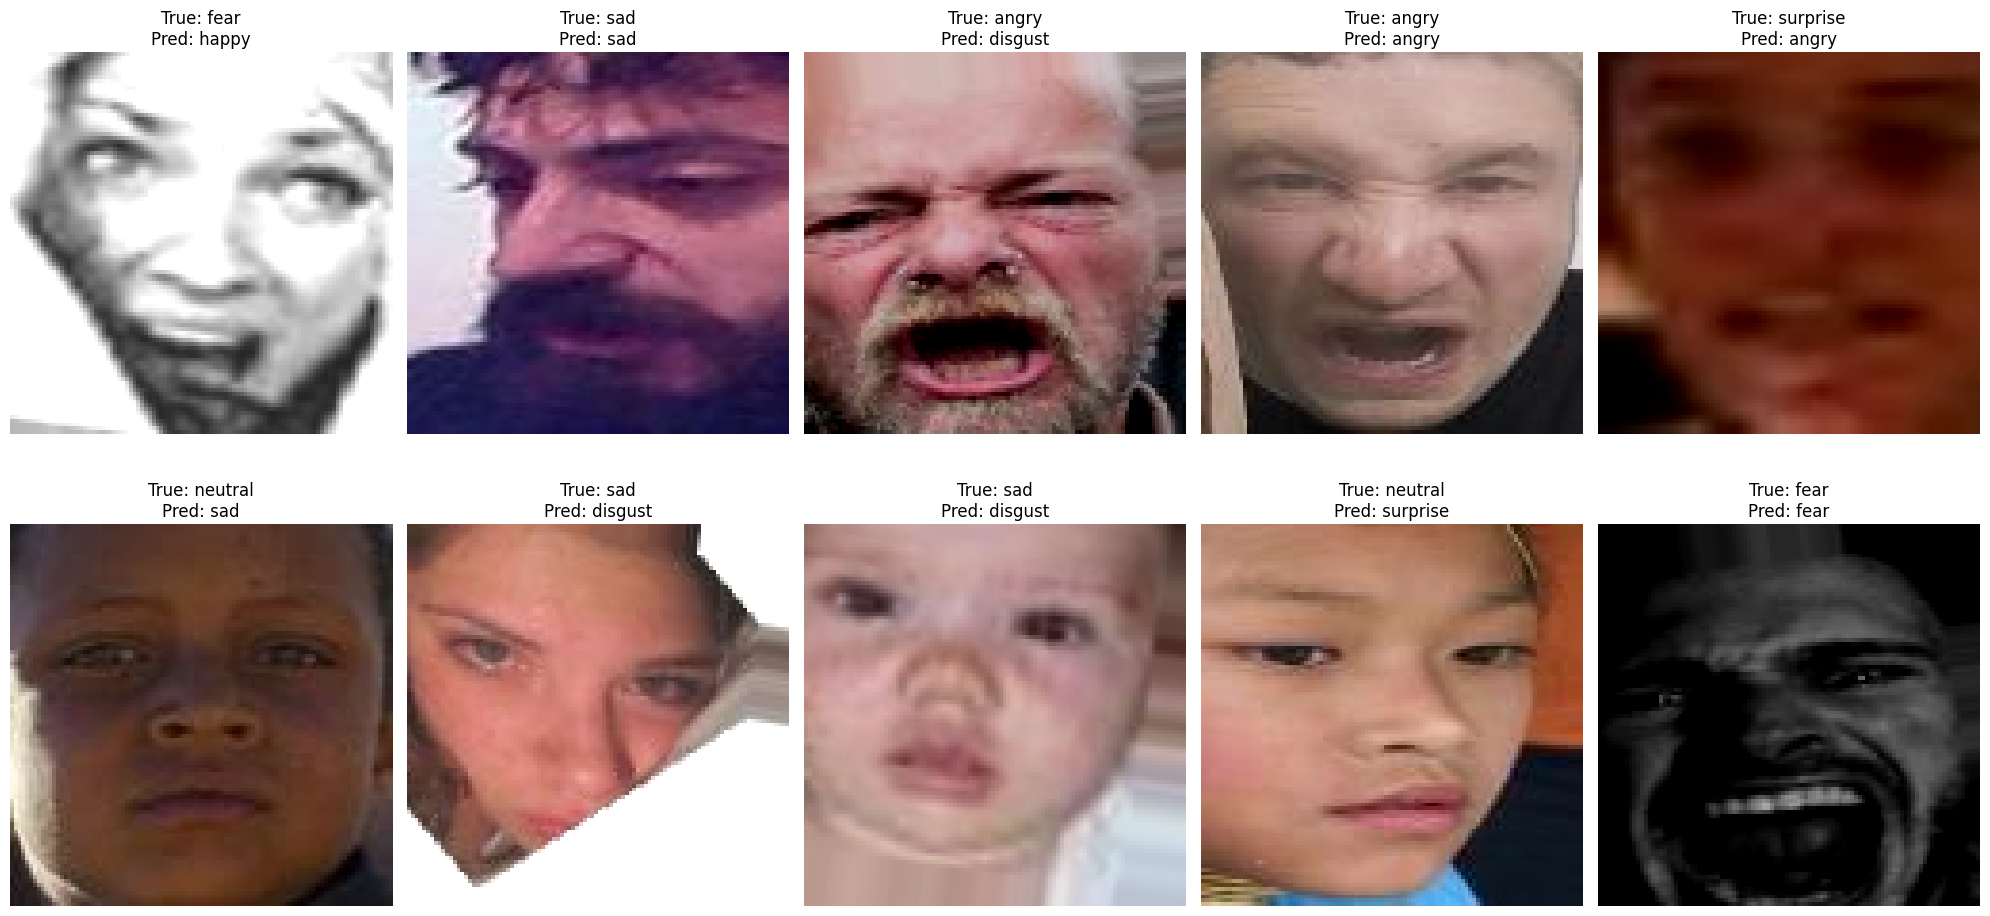

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows and 5 columns for 10 examples

# Select 10 random indices from the test set
random_indices = np.random.choice(len(test_images_normalized), 10, replace=False)

for i, idx in enumerate(random_indices):
    image = test_images_normalized[idx]
    true_class = classes[Y_test[idx] - 1]  # True class
    pred_class = classes[y_SVMpred[idx] - 1]  # Predicted class
    
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}')

plt.tight_layout()
plt.show()


In [27]:
# Clear memory
clear_session()
gc.collect()

0

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">CNN Model</p>

**CNN model**

In [28]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_CNNreshaped[0].shape)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,881,991 (18.62 MB)

 Trainable params: 4,881,991 (18.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the CNN model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

CNN_History = cnn_model.fit(
    train_generator,
    epochs=60, 
    batch_size = 32,
    validation_data=(test_images_CNNreshaped, Y_test_cat), 
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


285/288 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2012 - loss: 1.8941
Epoch 1: val_accuracy improved from -inf to 0.31020, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.2017 - loss: 1.8935 - val_accuracy: 0.3102 - val_loss: 1.7369 - learning_rate: 0.0010
Epoch 2/60
285/288 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3279 - loss: 1.7188
Epoch 2: val_accuracy improved from 0.31020 to 0.42367, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.3283 - loss: 1.7180 - val_accuracy: 0.4237 - val_loss: 1.5002 - learning_rate: 0.0010
Epoch 3/60
285/288 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4420 - loss: 1.4998
Epoch 3: val_accuracy improved from 0.42367 to 0.51167, saving model to best_CNNModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.4422 - loss: 1.4993 - val_accuracy: 0.5117 - val_loss: 1.3092 - learning_rate: 0.0010
Epoch 4/60
285/288 ━━━━━━━━━━━━━━━━━━━━ 0s

In [30]:
CNN_History.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

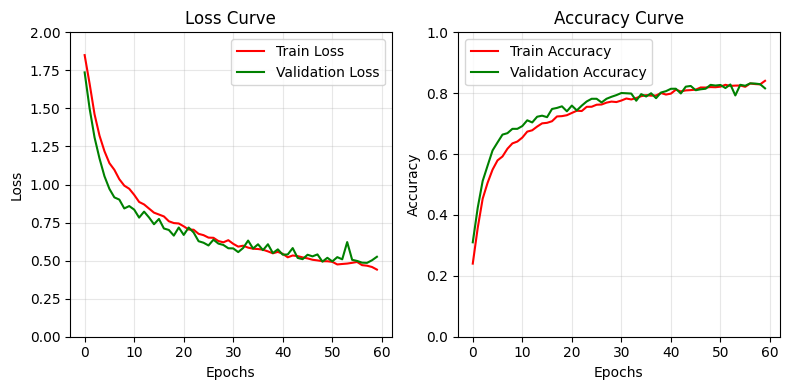

In [31]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()

In [32]:
train_CNNresult = cnn_model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_CNNresult = cnn_model.evaluate(test_images_CNNreshaped, Y_test_cat)

# Evaluate the CNN model
print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))

575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9059 - loss: 0.2589
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8233 - loss: 0.5049
Train Loss: 26.00%
Train Accuracy: 90.69%

Test Loss: 48.67%
Test Accuracy: 83.23%


In [33]:
# Predict on the test set
y_predCNN_prob = cnn_model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predCNN = np.argmax(y_predCNN_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predCNN, target_names=classes))

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.85      0.88      0.86       870
        fear       0.97      0.88      0.92       840
     disgust       0.82      0.75      0.79       910
       happy       0.85      0.88      0.86       887
         sad       0.79      0.75      0.77       865
       angry       0.89      0.89      0.89       859
     neutral       0.69      0.80      0.74       894

    accuracy                           0.83      6125
   macro avg       0.84      0.83      0.83      6125
weighted avg       0.84      0.83      0.83      6125



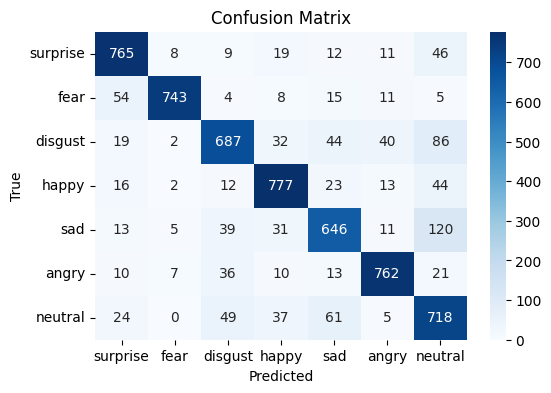

In [34]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predCNN)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

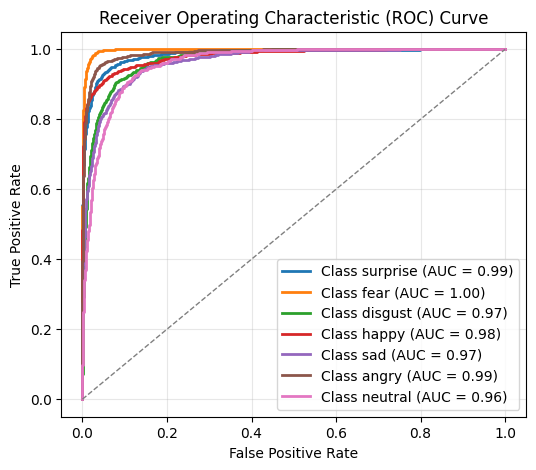

In [35]:
# Binarize the true labels for multi-class ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

# Initialisation des FPR, TPR, et AUC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}

# Calcul des courbes ROC et de l'AUC pour chaque classe
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predCNN_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Ligne de référence pour une prédiction aléatoire
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Personnalisation du graphique
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

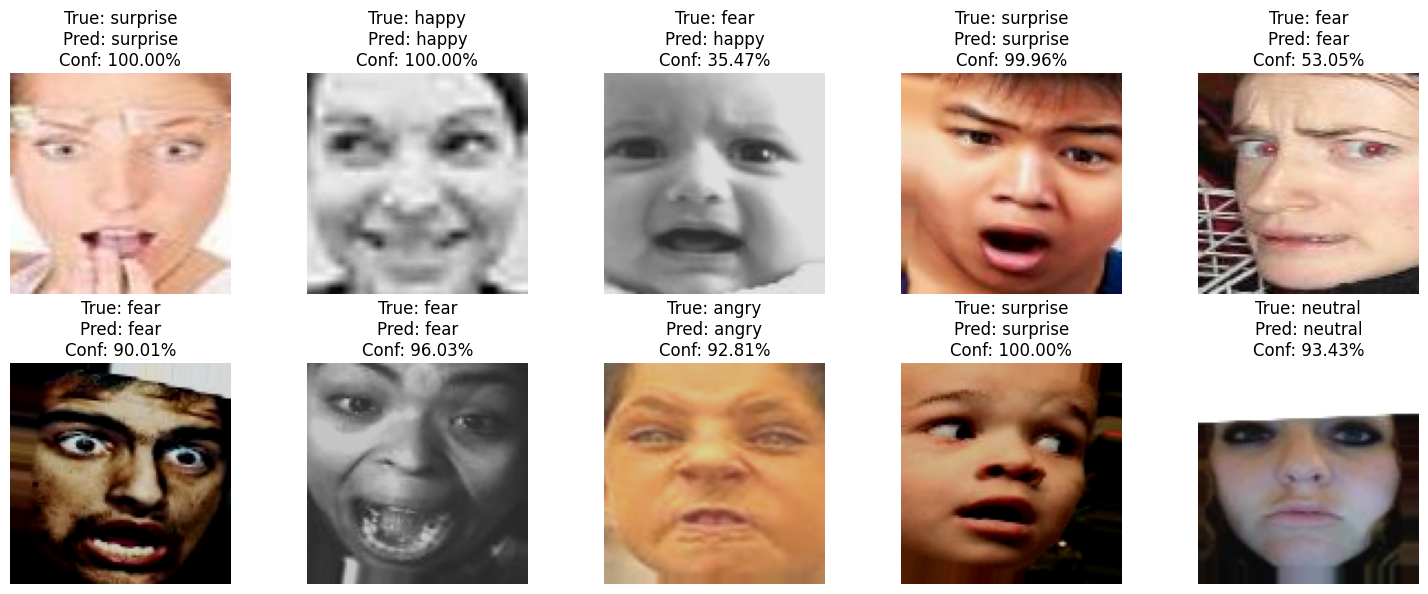

In [36]:
random_indices = np.random.choice(len(test_images_CNNreshaped), 10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image = test_images_CNNreshaped[idx]
    true_class = classes[Y_test[idx] - 1]  
    pred_class = classes[y_predCNN[idx]]  
    confidence = np.max(y_predCNN_prob[idx]) * 100   
    
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')  
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%')

plt.tight_layout()
plt.show()

In [37]:
del CNN_History, train_loss, val_loss, train_accuracy, val_accuracy, train_CNNresult
# Clear memory
clear_session()
gc.collect()

0

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">DenseNet Model</p>

**DenseNet model**

In [38]:
# Load the DenseNet model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(test_images_CNNreshaped[0].shape))

# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output_tensor  = Dense(len(classes), activation='softmax')(x)

DenseNet_model = Model(inputs=base_model.input, outputs=output_tensor)

# Freeze base layers of DenseNet
for layer in base_model.layers:
    layer.trainable = False

DenseNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
DenseNet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 106, 106, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 25, 25, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 25, 25, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 25, 25, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,565,895 (28.86 MB)

 Trainable params: 528,391 (2.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [40]:
# Train the DenseNet model
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_DenseNetModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

DenseNet_History = DenseNet_model.fit(
    train_generator, 
    epochs=60, 
    batch_size = 32,
    validation_data=(test_images_CNNreshaped, Y_test_cat), 
    callbacks=[reduce_lr, early_stop, checkpoint]
)


Epoch 1/60
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3343 - loss: 1.9026
Epoch 1: val_accuracy improved from -inf to 0.47020, saving model to best_DenseNetModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 93s 245ms/step - accuracy: 0.3346 - loss: 1.9009 - val_accuracy: 0.4702 - val_loss: 1.4089 - learning_rate: 0.0010
Epoch 2/60
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4430 - loss: 1.4740
Epoch 2: val_accuracy improved from 0.47020 to 0.50384, saving model to best_DenseNetModel.keras
288/288 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.4431 - loss: 1.4739 - val_accuracy: 0.5038 - val_loss: 1.3338 - learning_rate: 0.0010
Epoch 3/60
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4747 - loss: 1.3960
Epoch 3: val_accuracy did not improve from 0.50384
288/288 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.4747 - loss: 1.3960 - val_accuracy: 0.4999 - val_loss: 1.3231 - learning_rate: 0.0010
Epoch 4/60
287/288 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accura

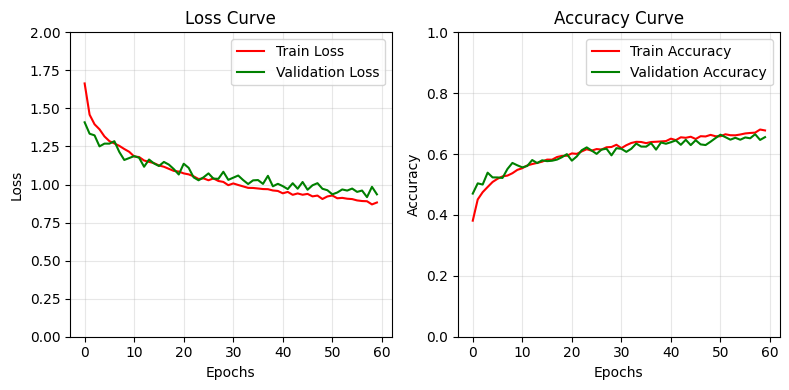

In [41]:
train_loss = DenseNet_History.history['loss']
val_loss = DenseNet_History.history['val_loss']
train_accuracy = DenseNet_History.history['accuracy']
val_accuracy = DenseNet_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss', color='red')
ax[0].plot(val_loss, label='Validation Loss', color='green')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy', color='red')
ax[1].plot(val_accuracy, label='Validation Accuracy', color='green')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()
plt.show()

In [42]:
train_DenseNetresult = DenseNet_model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_DenseNetresult = DenseNet_model.evaluate(test_images_CNNreshaped, Y_test_cat)

# Evaluate the CNN model
print("Train Loss: {:.2f}%".format(train_DenseNetresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_DenseNetresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_DenseNetresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_DenseNetresult[1] * 100))

575/575 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7765 - loss: 0.6380
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6699 - loss: 0.9047
Train Loss: 64.86%
Train Accuracy: 77.15%

Test Loss: 91.72%
Test Accuracy: 66.53%


In [43]:
# Predict on the test set
y_predDenseNet_prob = DenseNet_model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predDenseNet = np.argmax(y_predDenseNet_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predDenseNet, target_names=classes))

192/192 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.69      0.68      0.68       870
        fear       0.90      0.88      0.89       840
     disgust       0.69      0.55      0.61       910
       happy       0.59      0.73      0.65       887
         sad       0.61      0.48      0.54       865
       angry       0.81      0.72      0.76       859
     neutral       0.48      0.63      0.54       894

    accuracy                           0.67      6125
   macro avg       0.68      0.67      0.67      6125
weighted avg       0.68      0.67      0.67      6125



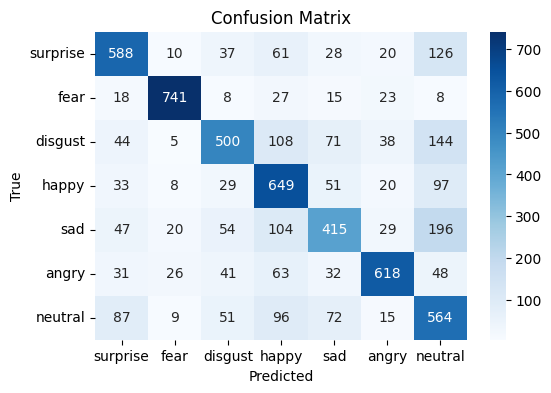

In [44]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predDenseNet)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

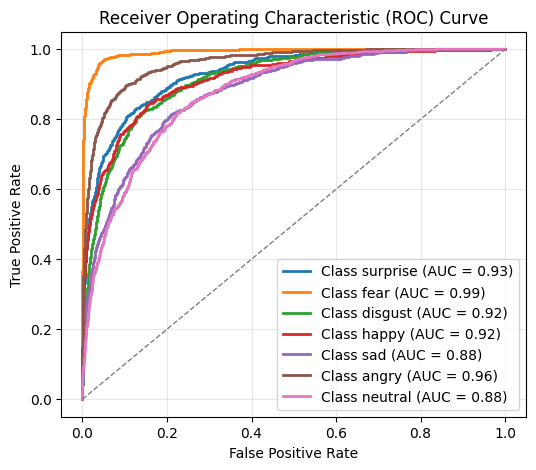

In [45]:
# Binarize the true labels for multi-class ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

# Initialisation des FPR, TPR, et AUC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}

# Calcul des courbes ROC et de l'AUC pour chaque classe
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predDenseNet_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer toutes les courbes ROC
plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Ligne de référence pour une prédiction aléatoire
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Personnalisation du graphique
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

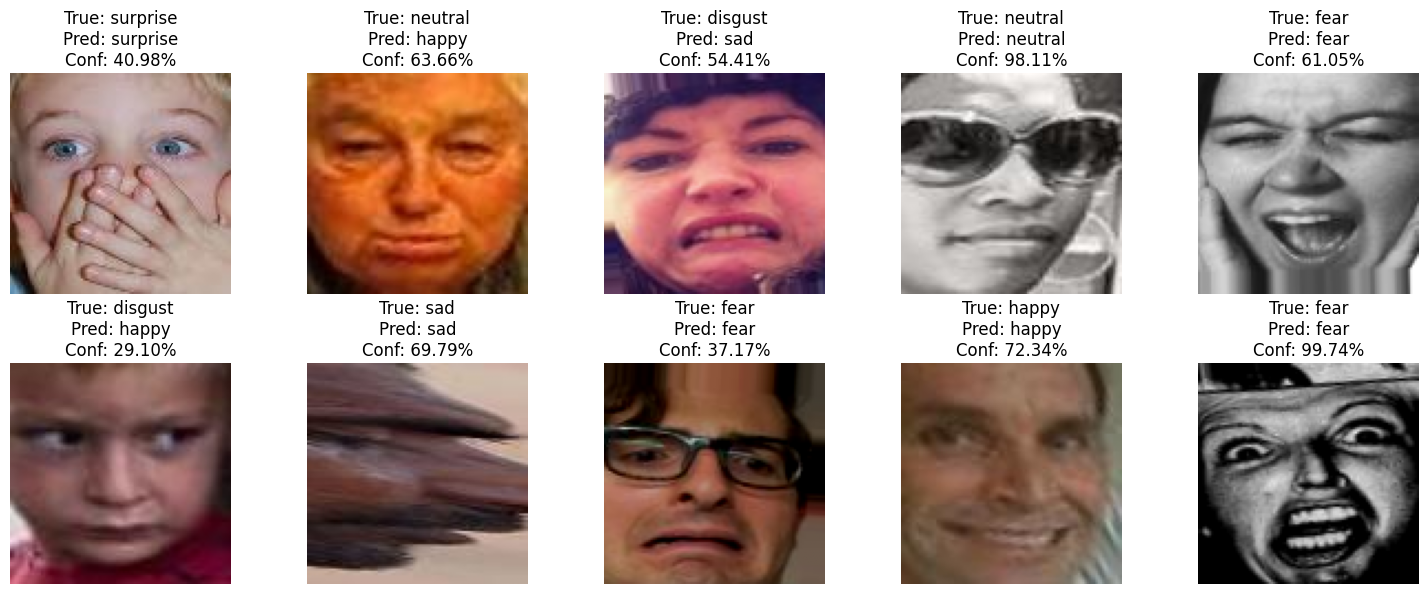

In [46]:
random_indices = np.random.choice(len(test_images_CNNreshaped), 10, replace=False)

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    image = test_images_CNNreshaped[idx]
    true_class = classes[Y_test[idx] - 1]  
    pred_class = classes[y_predDenseNet[idx]]  
    confidence = np.max(y_predDenseNet_prob[idx]) * 100 
    # Plotting
    ax[i // 5, i % 5].imshow(image)
    ax[i // 5, i % 5].axis('off')  
    ax[i // 5, i % 5].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%')

plt.tight_layout()
plt.show()

In [47]:
del DenseNet_History, train_loss, val_loss, train_accuracy, val_accuracy, train_DenseNetresult
# Clear memory
clear_session()
gc.collect()

0

# <p style="color:white;background-color:#E17A8A;font-family:newtimeroman;font-size:130%;text-align:center;border-radius:50px 10px;">Save the best model</p>

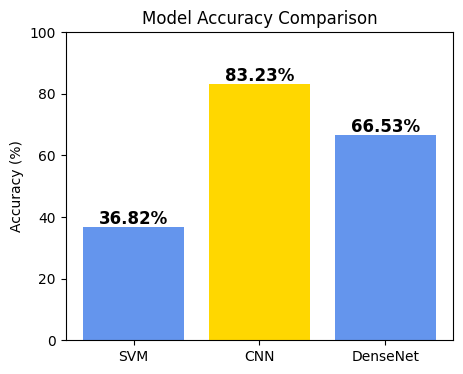

In [48]:
# Comparison of accuracies
svm_accuracy = accuracy_score(Y_test, y_SVMpred) * 100
cnn_accuracy = test_CNNresult[1] * 100
DenseNet_accuracy = test_DenseNetresult[1] * 100

# Models and their accuracies
models = ['SVM', 'CNN', 'DenseNet']
accuracies = [ svm_accuracy, cnn_accuracy, DenseNet_accuracy]

# Determine the index of the best model
best_accuracy = max(accuracies)
best_model_index = accuracies.index(best_accuracy)

# Create a chart with different colors for the best model
colors = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue']
colors[best_model_index] = 'gold'

# create graph
plt.figure(figsize=(5, 4))
bars = plt.bar(models, accuracies, color=colors)

# Add the percentages above the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f'{accuracy:.2f}%', ha='center', fontweight='bold', fontsize=12)

plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 100])

# show graph
plt.show()


In [49]:
best_model = models[best_model_index]
if best_model == 'SVM':
    model_file = 'best_model_svm.pkl'
    joblib.dump(svm_model, model_file)
elif best_model in ['CNN', 'DenseNet']:
    model_file = 'best_model.h5'
    if best_model == 'CNN':
        cnn_model.save(model_file)
    elif best_model == 'DenseNet':
        DenseNet_model.save(model_file)

print(f"The best model is {best_model} and has been saved as {model_file}")

The best model is CNN and has been saved as best_model.h5


# *<center> Thank You for Reading 🙏 </center>*
*<center> **Thank you for taking the time to explore this notebook!** Your feedback and suggestions are always welcome.</center>*

*<center>  If you found this helpful or inspiring, please consider **upvoting** the notebook to support my work. 😊</center>*



*<center>👉 Feel free to explore more of my work on my Kaggle profile:  [My Kaggle Profile](https://www.kaggle.com/dhaouadiibtihel98)<center>*